In [27]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import tarfile
import urllib.request
import email
import email.policy

## 메일 데이터 가져오기

In [28]:
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
# 파일을 저장할 로컬 디렉토리 경로
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        # 압축해제
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [29]:
fetch_spam_data()

In [30]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
#폴더 안에 있는 파일들의 이름이 20글자가 넘어가면 For문을 통해 투입
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [31]:
print('일반 메일 갯수 :', len(ham_filenames))
print('스팸 메일 갯수 :', len(spam_filenames))

일반 메일 갯수 : 2500
스팸 메일 갯수 : 500


## 메일 정보 확인하기

In [32]:
def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [33]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [34]:
#일반메일은 어떤식으로 생겼는가?
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [35]:
#스팸메일은 어떻게 생겼는가
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [36]:
# 어떤 이메일은 이미지나 첨부 파일을 가지는 multipart다. 이러한 구조를 확인한다. 

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [37]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [38]:
structures_counter(ham_emails).most_common()

# 일반 이메일은 대부분이 text/plain 인데

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [39]:
structures_counter(spam_emails).most_common()

# 스팸 메일은 text/html 많이 가지고 있다.

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [40]:
# 첫번째 스팸 메일의 헤더를 알아보자.

for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [41]:
# 첫번째 스팸 메일의 제목

spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

## 학습시키기

In [42]:
from sklearn.model_selection import train_test_split

# 일반 메일과 스팸 메일을 피쳐로 총 3000개의 피쳐
X = np.array(ham_emails + spam_emails, dtype=object)

# 일반메일 2500개는 0의 타겟, 500개는 1의 타겟으로 총 3000개의 타겟
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

# 훈련시킴
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

## 데이터 전처리 하기 ##

In [43]:
# 정규 표현 방식을 이용해서 html을 plain text로 변경한다.
# <head> 섹션을 삭제하고 모든 <a>태그를 HIYERLINK 문자로 바꾸고, HTML 태그를 제거하고 텍스트만 남긴다.
# 가독성을 위하여 여러 개행 문자를 하나로 만들고 html언어를 복원한다.

import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [44]:
# html 스팸메일 확인해보는데 이 부분은 잘 모르겠다.

html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML>
<HEAD>
</HEAD>
<BODY>
<FONT SIZE="4"><B> A man endowed with a 7 - 8" hammer is simply<br>
 better equipped than a man with a 5 - 6" hammer. <BR>
<BR>Would you rather have<br>more than enough to get the job done or fall very short. It's totally up<br>to you. Our Methods are guaranteed to increase your size by 1 - 3"<br> <A HREF="http://202.109.114.136/index.php?10004">Enter here and see how</A>
</BODY>
</HTML> ...


In [45]:
# html을 plain으로 변경시키면 이렇게 나온다
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


 A man endowed with a 7 - 8" hammer is simply
 better equipped than a man with a 5 - 6" hammer.
Would you rather havemore than enough to get the job done or fall very short. It's totally upto you. Our Methods are guaranteed to increase your size by 1 - 3"  HYPERLINK Enter here and see how
 ...


In [46]:
# 포멧에 상관없이 텍스트로 변형시켜주는 함수 생성

def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [47]:
print(email_to_text(sample_html_spam)[:100], "...")


 A man endowed with a 7 - 8" hammer is simply
 better equipped than a man with a 5 - 6" hammer.
Wou ...


In [48]:
# 어간 추출해보면서 nltk 확인

try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [49]:
# url 추출을 위한 모듈 다운
! pip3 install urlextract

In [50]:
# url 추출 잘 되는지 확인

try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [51]:
# 문장을 파이선 split() 함수를 이용해서 분리하고 갯수를 세는 함수를 만든다.
# 실질적 

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
from nltk.corpus import stopwords
from nltk import word_tokenize
words_to_remove = stopwords.words('english')  
import string


class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            text = word_tokenize(text)
            #word_counts = Counter(text.split())
            #text = [word for word in text  
                       #if word not in words_to_remove]         
            word_counts = Counter(text)
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [52]:
# 3개의 이메일을 분석해본다

X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'in': 6, 'of': 5, 'and': 5, 'the': 5, 'you': 5, 'r': 4, 'that': 3, 'i': 3, 'a': 3, 'eateri': 3, 'toronto': 3, 'are': 3, 'not': 3, 'com': 2, 't': 2, 'as': 2, 'have': 2, 'varieti': 2, 'good': 2, 'local': 2, 'strip': 2, 'but': 2, 'neighbourhood': 2, 'more': 2, 'than': 2, 'or': 2, 'there': 2, 'like': 2, 'can': 2, 'at': 2, 'doe': 2, 'live': 2, 'commun': 2, 'russel': 1, 'turpin': 1, 'deafbox': 1, 'hotmail': 1, 'write': 1, 'thing': 1, 'aren': 1, 'all': 1, 'bad': 1, 'rememb': 1, 'vancouv': 1, 'broad': 1, 'joint': 1, 'haven': 1, 'been': 1, 'to': 1, 'van': 1, 'year': 1, 'do': 1, 'know': 1, 'outsid': 1, 'small': 1, 'deepli': 1, 'ethnic': 1, 'if': 1, 'stray': 1, 'number': 1, 'feet': 1, 'from': 1, 'wellesley': 1, 'jarvi': 1, 'queen': 1, 'spadina': 1, 're': 1, 'doughnutland': 1, 's': 1, 'far': 1, 'eaton': 1, 'centr': 1, 'quaint': 1, 'cafe': 1, 'mccaul': 1, 'north': 1, 'dunda': 1, 'rare': 1, 'littl': 1, 'brim': 1, 'with': 1, 'lunchtim': 1, 'traffic': 1, 'still': 1, 'find': 1, 'seat': 

In [53]:
# 단어 개수를 확인 할 수 있게 됐다. 우리는 그것을 백터로 바꿔야 한다.

from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [54]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=20)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x21 sparse matrix of type '<class 'numpy.intc'>'
	with 51 stored elements in Compressed Sparse Row format>

In [55]:
# 배열의 첫번쨰 열은 단어장에 없는 단어의 갯수를 말한다. 
# 그담 열들은 단어장에 순서데로 있는 단어들의 갯수를 말한다.

X_few_vectors.toarray()

array([[138,   1,   5,   1,   6,   5,   5,   5,   1,   1,   0,   1,   2,
          3,   1,   0,   4,   3,   3,   2,   0],
       [ 86,  18,   6,  10,   4,   3,   0,   2,   4,   0,   5,   3,   2,
          2,   3,   4,   0,   0,   0,   2,   4],
       [ 60,   2,   1,   1,   1,   1,   3,   1,   2,   5,   1,   1,   1,
          0,   1,   1,   0,   1,   1,   0,   0]], dtype=int32)

In [56]:
# 단어장에 있는 단어들의 배열
vocab_transformer.vocabulary_

{'number': 1,
 'and': 2,
 'url': 3,
 'in': 4,
 'you': 5,
 'of': 6,
 'the': 7,
 'to': 8,
 's': 9,
 'thi': 10,
 'from': 11,
 'or': 12,
 'are': 13,
 'two': 14,
 'on': 15,
 'r': 16,
 'that': 17,
 'a': 18,
 'at': 19,
 'your': 20}

## 데이터 학습하고 예측하기

In [57]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [59]:
# 로지스틱 회귀로 예측 해보기

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.988, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... , score=0.990, total=   0.4s
[CV]  ................................................................
[CV] .................................... , score=0.980, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


0.9858333333333333

Precision: 98.94%
Recall: 93.00%


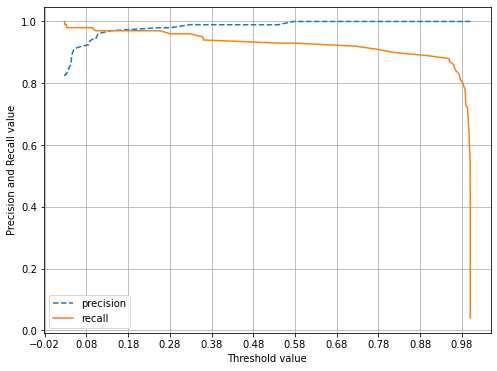

In [62]:
X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)
pred_proba1_log = log_clf.predict_proba(X_test_transformed)[:, 1]

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

precision_recall_curve_plot(y_test, pred_proba1_log)

In [63]:
# Lightgbm 학습기로 학습시켜본다. 근데 정확도가 100퍼센트라 이상하다 뭔가.

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators =400, num_leaves=64, n_jops=1, boost_from_average = False)

X_train_transformed = X_train_transformed.astype('float32')
X_test_transformed = X_test_transformed.astype('float32')   


evals = [(X_test_transformed, y_test)]
lgbm.fit(X_train_transformed, y_train, early_stopping_rounds = 100, eval_metric= 'logloss',
                eval_set=evals, verbose=True)

y_pred_lgbm = lgbm.predict(X_test_transformed)
pred_proba1_lgbm = lgbm.predict_proba(X_test_transformed)[:, 1]

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred_lgbm)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred_lgbm)))

[LightGBM] [Warning] Unknown parameter: n_jops
[1]	valid_0's binary_logloss: 0.611903
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.546272
[3]	valid_0's binary_logloss: 0.491254
[4]	valid_0's binary_logloss: 0.445734
[5]	valid_0's binary_logloss: 0.405799
[6]	valid_0's binary_logloss: 0.370172
[7]	valid_0's binary_logloss: 0.339549
[8]	valid_0's binary_logloss: 0.31182
[9]	valid_0's binary_logloss: 0.285379
[10]	valid_0's binary_logloss: 0.265167
[11]	valid_0's binary_logloss: 0.246106
[12]	valid_0's binary_logloss: 0.227358
[13]	valid_0's binary_logloss: 0.209726
[14]	valid_0's binary_logloss: 0.195632
[15]	valid_0's binary_logloss: 0.182727
[16]	valid_0's binary_logloss: 0.172159
[17]	valid_0's binary_logloss: 0.161728
[18]	valid_0's binary_logloss: 0.152363
[19]	valid_0's binary_logloss: 0.143986
[20]	valid_0's binary_logloss: 0.13532
[21]	valid_0's binary_logloss: 0.12876
[22]	valid_0's binary_logloss: 0.121809
[23]	valid_0's binary_l

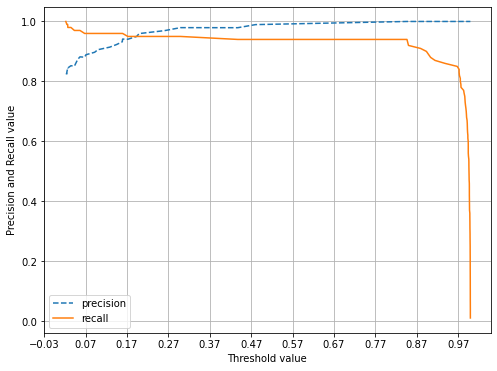

In [64]:
# lightgbm

precision_recall_curve_plot(y_test, pred_proba1_lgbm)

In [65]:
# 랜덤 포레스트 학습기로 했는데도 정확도가 100프로가 나온다.

from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

rf_clf = RandomForestClassifier(random_state =0)
rf_clf.fit(X_train_transformed, y_train)
pred_rf = rf_clf.predict(X_test_transformed)
pred_proba1_rf = rf_clf.predict_proba(X_test_transformed)[:, 1]

print("Precision: {:.2f}%".format(100 * precision_score(y_test, pred_rf)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, pred_rf)))

Precision: 100.00%
Recall: 89.00%


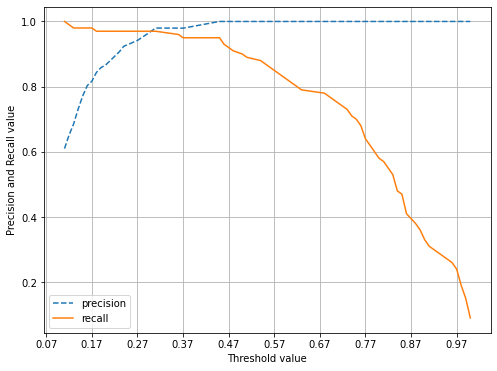

In [66]:
precision_recall_curve_plot(y_test, pred_proba1_rf)

In [67]:
import pandas as pd
import seaborn as sns

board = []
for i in range(1,1001):
    board.append('v'+str(i))
board.insert(0,'not_in_V')

a = pd.DataFrame(X_train_transformed.toarray(),columns=board)
a['target'] = y_train

corr = a.corr()

<AxesSubplot:>

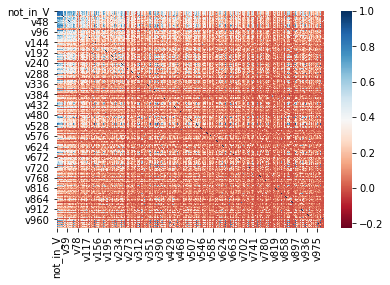

In [68]:
sns.heatmap(corr, cmap='RdBu')

# 이상치 제거를 위해서 전체적인 plt를 보고 싶은데 힘들다 ..

##  첫째열 제거하는 전처리 과정 해보기

In [69]:
board = []
for i in range(1,1001):
    board.append('v'+str(i))
board.insert(0,'not_in_V')

X_transformed = preprocess_pipeline.fit_transform(np.array(ham_emails + spam_emails, dtype=object))
c = pd.DataFrame(X_transformed.toarray(),columns=board)

In [70]:
c

,not_in_V,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v991,v992,v993,v994,v995,v996,v997,v998,v999,v1000
0,59,39,15,1,1,2,5,5,1,4,...,0,0,0,0,0,0,0,0,0,0
1,35,4,5,3,3,3,3,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,67,5,16,11,4,10,5,0,3,1,...,0,0,0,0,0,0,0,0,0,0
3,54,6,9,3,3,4,7,0,2,1,...,0,0,0,0,0,0,0,0,0,3
4,36,1,4,8,3,2,5,4,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,27,5,5,0,0,1,3,0,3,1,...,0,0,0,0,0,0,0,0,0,0
2996,5,0,1,3,0,1,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2997,19,7,5,6,3,2,3,0,2,1,...,0,0,0,0,0,0,0,0,0,0
2998,118,17,25,27,13,17,8,6,7,12,...,0,0,0,0,0,0,0,0,1,0


In [71]:
# 첫번째 열이 공통된 단어장에 있지 않은 단어들의 배열이므로 제거시켜보고 다시 해본다. 
New_data = c.drop('not_in_V',axis =1)

In [72]:
a

,not_in_V,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v992,v993,v994,v995,v996,v997,v998,v999,v1000,target
0,58.0,1.0,5.0,1.0,3.0,5.0,5.0,3.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,24.0,18.0,2.0,4.0,0.0,6.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,18.0,2.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,16.0,18.0,4.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,9.0,0.0,5.0,2.0,3.0,1.0,3.0,4.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,7.0,6.0,5.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2396,18.0,0.0,8.0,3.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2397,17.0,10.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2398,335.0,74.0,75.0,98.0,81.0,93.0,57.0,14.0,32.0,27.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1


In [73]:
New_data

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v991,v992,v993,v994,v995,v996,v997,v998,v999,v1000
0,39,15,1,1,2,5,5,1,4,1,...,0,0,0,0,0,0,0,0,0,0
1,4,5,3,3,3,3,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
2,5,16,11,4,10,5,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
3,6,9,3,3,4,7,0,2,1,3,...,0,0,0,0,0,0,0,0,0,3
4,1,4,8,3,2,5,4,2,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,5,5,0,0,1,3,0,3,1,1,...,0,0,0,0,0,0,0,0,0,0
2996,0,1,3,0,1,2,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2997,7,5,6,3,2,3,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
2998,17,25,27,13,17,8,6,7,12,3,...,0,0,0,0,0,0,0,0,1,0


## 새로운 데이터로 다시 학습

In [74]:
Z_train, Z_test, w_train, w_test = train_test_split(New_data, y, test_size=0.2, random_state=42, stratify = y)

In [75]:
log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, Z_train, w_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.988, total=   0.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .................................... , score=0.986, total=   0.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV] .................................... , score=0.988, total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


0.9870833333333332

In [76]:
# 다시 로지스틱 회귀로 예측해본다

log_clf.fit(Z_train, w_train)

w_pred2_log = log_clf.predict(Z_test)

pred_proba2_log = log_clf.predict_proba(Z_test)[:, 1]

print("Precision: {:.2f}%".format(100 * precision_score(w_test, w_pred2_log)))
print("Recall: {:.2f}%".format(100 * recall_score(w_test, w_pred2_log)))

Precision: 100.00%
Recall: 93.00%


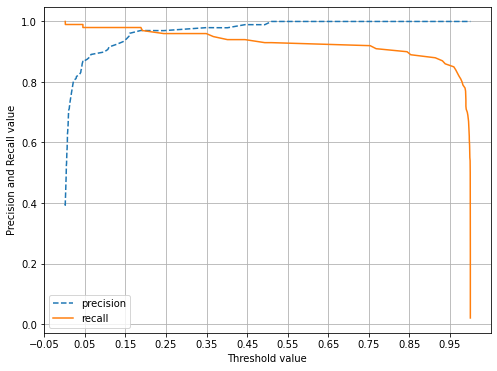

In [77]:
precision_recall_curve_plot(w_test, pred_proba2_log)

In [78]:
# Lightgbm으로 다시 해본다.

Z_train_transformed = Z_train.astype('float32')
Z_test_transformed = Z_test.astype('float32')   


evals = [(Z_test, w_test)]
lgbm.fit(Z_train, w_train, early_stopping_rounds = 200, eval_metric= 'logloss',
                eval_set=evals, verbose=True)

w_pred2_lgbm = lgbm.predict(Z_test)
pred_proba2_lgbm = lgbm.predict_proba(Z_test)[:, 1]

print("Precision: {:.2f}%".format(100 * precision_score(w_test, w_pred2_lgbm)))
print("Recall: {:.2f}%".format(100 * recall_score(w_test, w_pred2_lgbm)))

[LightGBM] [Warning] Unknown parameter: n_jops
[1]	valid_0's binary_logloss: 0.611843
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.546184
[3]	valid_0's binary_logloss: 0.491194
[4]	valid_0's binary_logloss: 0.445397
[5]	valid_0's binary_logloss: 0.405525
[6]	valid_0's binary_logloss: 0.369836
[7]	valid_0's binary_logloss: 0.339316
[8]	valid_0's binary_logloss: 0.311667
[9]	valid_0's binary_logloss: 0.284929
[10]	valid_0's binary_logloss: 0.264043
[11]	valid_0's binary_logloss: 0.245526
[12]	valid_0's binary_logloss: 0.226694
[13]	valid_0's binary_logloss: 0.211852
[14]	valid_0's binary_logloss: 0.197508
[15]	valid_0's binary_logloss: 0.18427
[16]	valid_0's binary_logloss: 0.173051
[17]	valid_0's binary_logloss: 0.162228
[18]	valid_0's binary_logloss: 0.152547
[19]	valid_0's binary_logloss: 0.145244
[20]	valid_0's binary_logloss: 0.137276
[21]	valid_0's binary_logloss: 0.129731
[22]	valid_0's binary_logloss: 0.124225
[23]	valid_0's binary

[255]	valid_0's binary_logloss: 0.0644887
[256]	valid_0's binary_logloss: 0.0645308
[257]	valid_0's binary_logloss: 0.0645726
[258]	valid_0's binary_logloss: 0.0645967
[259]	valid_0's binary_logloss: 0.0646099
[260]	valid_0's binary_logloss: 0.064764
[261]	valid_0's binary_logloss: 0.0647314
[262]	valid_0's binary_logloss: 0.0648063
[263]	valid_0's binary_logloss: 0.0646447
[264]	valid_0's binary_logloss: 0.064671
[265]	valid_0's binary_logloss: 0.0645616
[266]	valid_0's binary_logloss: 0.0646501
[267]	valid_0's binary_logloss: 0.064627
[268]	valid_0's binary_logloss: 0.0646944
[269]	valid_0's binary_logloss: 0.0646585
[270]	valid_0's binary_logloss: 0.0648717
[271]	valid_0's binary_logloss: 0.0647544
[272]	valid_0's binary_logloss: 0.0645998
[273]	valid_0's binary_logloss: 0.0647401
[274]	valid_0's binary_logloss: 0.0648041
[275]	valid_0's binary_logloss: 0.0648029
[276]	valid_0's binary_logloss: 0.0649415
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0414705
Pre

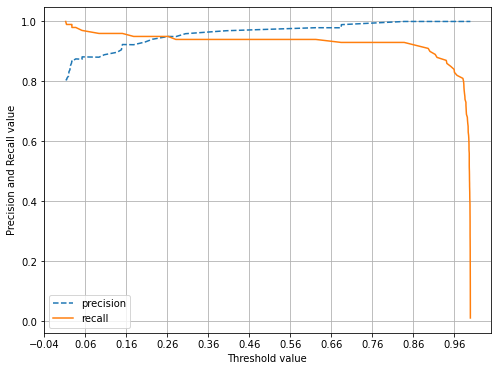

In [79]:
precision_recall_curve_plot(w_test, pred_proba2_lgbm)

In [80]:
# 랜덤 포레스트로

rf_clf.fit(Z_train, w_train)
pred2_rf = rf_clf.predict(Z_test)
pred_proba2_rf = rf_clf.predict_proba(Z_test)[:, 1]

print("Precision: {:.2f}%".format(100 * precision_score(w_test, pred2_rf)))
print("Recall: {:.2f}%".format(100 * recall_score(w_test, pred2_rf)))

Precision: 100.00%
Recall: 91.00%


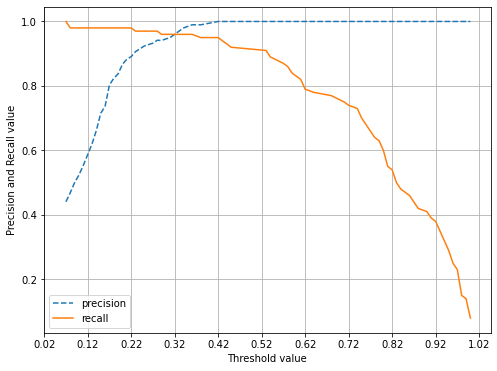

In [81]:
precision_recall_curve_plot(w_test, pred_proba2_rf)

### word_tokenizer 한 후에, 불용어 제거하지 않고,  train_test_split을 stratify=y 하게 하고, 데이터 첫째열 제거한 RogisticRegression이 정밀도 100%, 재현율 93%에 가장 합리적인 으로 나왔다. 스팸 필터이므로 정밀도가 재현율보다는 더 중요할 것이다.